In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder

from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
#Remove the ID column
df.info()
df.drop('id', axis=1, inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=0))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [5]:
##Label Encode Binary
residence_type = df['Residence_type'].unique()
ever_married = df['ever_married'].unique()
le = LabelEncoder()

le.fit(residence_type)
df['Residence_type'] = le.transform(df['Residence_type'])

le.fit(ever_married)
df['ever_married'] = le.transform(df['ever_married'])

In [6]:
df
#Label Encode -> One Hot Encode -> PCA -> Splitting -> Outlier Detection -> SMOTE X_train and y_train -> Bayes Training

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,29.879487,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.400000,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,1,Private,1,83.75,28.476923,never smoked,0
5106,Female,81.0,0,0,1,Self-employed,1,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,1,Self-employed,0,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,1,Private,0,166.29,25.600000,formerly smoked,0


In [7]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 
       'avg_glucose_level', 'bmi', 'smoking_status']]
y = df['stroke']

In [8]:
#One Hot Encode everything
encoder = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ['gender', 'work_type', 'smoking_status'])], remainder='passthrough')
X = np.array(encoder.fit_transform(X))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
#Standardize
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
#Isolation Forest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

In [12]:
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]

In [13]:
#ROS
X_ros, y_ros = RandomOverSampler().fit_resample(X_train, y_train)

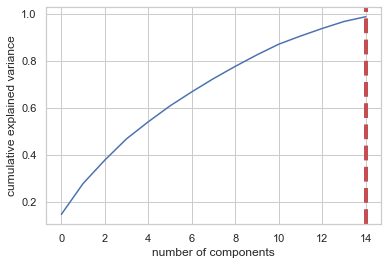

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.147557,0.147557
1,0.278531,0.130974
2,0.377939,0.099408
3,0.468356,0.090417
4,0.540715,0.072359
5,0.608190,0.067475
6,0.667686,0.059496
7,0.724026,0.056340
8,0.775918,0.051892
9,0.824861,0.048943


In [14]:
pca_test = PCA(n_components=15)
pca_test.fit(X_ros)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=14, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(15))

In [15]:
pca = PCA(n_components=12)
X_ros = pca.fit_transform(X_ros)
X_test = pca.fit_transform(X_test)

# ANN

In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential  
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers

In [17]:
def ann_classifier(optimizer = 'adam'):
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), activation=tf.nn.relu))
    model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), activation=tf.nn.relu))
    tf.keras.layers.Dropout(0.6)
    model.add(layers.Dense(1, activation=tf.nn.sigmoid))
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [18]:
ann = KerasClassifier(build_fn = ann_classifier, batch_size = 32, epochs = 50)

# Before tuning

In [19]:
prior_model = tf.keras.models.Sequential()
prior_model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), activation=tf.nn.relu))
prior_model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), activation=tf.nn.relu))
tf.keras.layers.Dropout(0.4)
prior_model.add(layers.Dense(1, activation=tf.nn.sigmoid))
prior_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
epochs = 100
prior_model.fit(X_ros, y_ros, epochs=epochs)

Epoch 1/100
221/221 [==============================] - 1s 518us/step - loss: 0.8300 - accuracy: 0.5713
Epoch 2/100
221/221 [==============================] - 0s 518us/step - loss: 0.6558 - accuracy: 0.7385
Epoch 3/100
221/221 [==============================] - 0s 537us/step - loss: 0.5816 - accuracy: 0.7646
Epoch 4/100
221/221 [==============================] - 0s 534us/step - loss: 0.5536 - accuracy: 0.7608
Epoch 5/100
221/221 [==============================] - 0s 523us/step - loss: 0.5387 - accuracy: 0.7595
Epoch 6/100
221/221 [==============================] - 0s 482us/step - loss: 0.5290 - accuracy: 0.7629
Epoch 7/100
221/221 [==============================] - 0s 504us/step - loss: 0.5218 - accuracy: 0.7649
Epoch 8/100
221/221 [==============================] - 0s 530us/step - loss: 0.5147 - accuracy: 0.7707
Epoch 9/100
221/221 [==============================] - 0s 482us/step - loss: 0.5100 - accuracy: 0.7721
Epoch 10/100
221/221 [==============================] - 0s 459us/step - l

221/221 [==============================] - 0s 564us/step - loss: 0.4357 - accuracy: 0.8197
Epoch 80/100
221/221 [==============================] - 0s 532us/step - loss: 0.4338 - accuracy: 0.8249
Epoch 81/100
221/221 [==============================] - 0s 546us/step - loss: 0.4345 - accuracy: 0.8219
Epoch 82/100
221/221 [==============================] - 0s 532us/step - loss: 0.4348 - accuracy: 0.8231
Epoch 83/100
221/221 [==============================] - 0s 523us/step - loss: 0.4345 - accuracy: 0.8177
Epoch 84/100
221/221 [==============================] - 0s 509us/step - loss: 0.4339 - accuracy: 0.8219
Epoch 85/100
221/221 [==============================] - 0s 505us/step - loss: 0.4343 - accuracy: 0.8229
Epoch 86/100
221/221 [==============================] - 0s 468us/step - loss: 0.4335 - accuracy: 0.8232
Epoch 87/100
221/221 [==============================] - 0s 479us/step - loss: 0.4333 - accuracy: 0.8233
Epoch 88/100
221/221 [==============================] - 0s 464us/step - loss:

In [21]:
test_loss, test_acc = prior_model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 419us/step - loss: 0.9947 - accuracy: 0.5020


In [22]:
y_pred=(prior_model.predict(X_test) > 0.5).astype("int32")

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
roc = roc_auc_score(y_test, y_pred)
print('ROC score: %f' % roc)
print('----------------------------')
print(classification_report(y_test, y_pred))

Accuracy: 0.501957
Precision: 0.085610
Recall: 0.870370
F1 score: 0.155887
ROC score: 0.675888
----------------------------
              precision    recall  f1-score   support

           0       0.99      0.48      0.65       968
           1       0.09      0.87      0.16        54

    accuracy                           0.50      1022
   macro avg       0.54      0.68      0.40      1022
weighted avg       0.94      0.50      0.62      1022



# Tune ANN

In [23]:
parameters = {'batch_size': [25, 32],
             'epochs': [50, 100, 150],
             'optimizer': ['adam', 'rmsprop']}

grid_search = GridSearchCV(estimator = ann, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)

grid_search.fit(X_ros, y_ros)

Epoch 1/150
283/283 [==============================] - 1s 472us/step - loss: 0.6979 - accuracy: 0.6915
Epoch 2/150
283/283 [==============================] - 0s 468us/step - loss: 0.5876 - accuracy: 0.7457
Epoch 3/150
283/283 [==============================] - 0s 479us/step - loss: 0.5494 - accuracy: 0.7586
Epoch 4/150
283/283 [==============================] - 0s 465us/step - loss: 0.5335 - accuracy: 0.7608
Epoch 5/150
283/283 [==============================] - 0s 466us/step - loss: 0.5229 - accuracy: 0.7670
Epoch 6/150
283/283 [==============================] - 0s 468us/step - loss: 0.5151 - accuracy: 0.7678
Epoch 7/150
283/283 [==============================] - 0s 463us/step - loss: 0.5092 - accuracy: 0.7694
Epoch 8/150
283/283 [==============================] - 0s 458us/step - loss: 0.5032 - accuracy: 0.7726
Epoch 9/150
283/283 [==============================] - 0s 461us/step - loss: 0.4984 - accuracy: 0.7757
Epoch 10/150
283/283 [==============================] - 0s 468us/step - l

283/283 [==============================] - 0s 465us/step - loss: 0.4164 - accuracy: 0.8317
Epoch 80/150
283/283 [==============================] - 0s 465us/step - loss: 0.4158 - accuracy: 0.8352
Epoch 81/150
283/283 [==============================] - 0s 468us/step - loss: 0.4164 - accuracy: 0.8297
Epoch 82/150
283/283 [==============================] - 0s 472us/step - loss: 0.4142 - accuracy: 0.8328
Epoch 83/150
283/283 [==============================] - 0s 468us/step - loss: 0.4133 - accuracy: 0.8332
Epoch 84/150
283/283 [==============================] - 0s 461us/step - loss: 0.4130 - accuracy: 0.8352
Epoch 85/150
283/283 [==============================] - 0s 472us/step - loss: 0.4129 - accuracy: 0.8345
Epoch 86/150
283/283 [==============================] - 0s 482us/step - loss: 0.4127 - accuracy: 0.8330
Epoch 87/150
283/283 [==============================] - 0s 461us/step - loss: 0.4120 - accuracy: 0.8315
Epoch 88/150
283/283 [==============================] - 0s 461us/step - loss:

GridSearchCV(cv=10,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000026011736C40>,
             n_jobs=-1,
             param_grid={'batch_size': [25, 32], 'epochs': [50, 100, 150],
                         'optimizer': ['adam', 'rmsprop']},
             scoring='accuracy')

In [24]:
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 81.90 %
Best Parameters: {'batch_size': 25, 'epochs': 150, 'optimizer': 'rmsprop'}


# Running ANN

In [25]:
model = tf.keras.models.Sequential()
model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), activation=tf.nn.relu))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), activation=tf.nn.relu))
tf.keras.layers.Dropout(0.4)
model.add(layers.Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
epochs = 150
model.fit(X_ros, y_ros, batch_size= 25, epochs=epochs)

Epoch 1/150
283/283 [==============================] - 1s 482us/step - loss: 0.7685 - accuracy: 0.6379
Epoch 2/150
283/283 [==============================] - 0s 464us/step - loss: 0.6328 - accuracy: 0.7163
Epoch 3/150
283/283 [==============================] - 0s 465us/step - loss: 0.5812 - accuracy: 0.7317
Epoch 4/150
283/283 [==============================] - 0s 497us/step - loss: 0.5565 - accuracy: 0.7492
Epoch 5/150
283/283 [==============================] - 0s 482us/step - loss: 0.5418 - accuracy: 0.7576
Epoch 6/150
283/283 [==============================] - 0s 486us/step - loss: 0.5324 - accuracy: 0.7601
Epoch 7/150
283/283 [==============================] - 0s 479us/step - loss: 0.5253 - accuracy: 0.7601
Epoch 8/150
283/283 [==============================] - 0s 475us/step - loss: 0.5179 - accuracy: 0.7687
Epoch 9/150
283/283 [==============================] - 0s 489us/step - loss: 0.5128 - accuracy: 0.7711
Epoch 10/150
283/283 [==============================] - 0s 468us/step - l

283/283 [==============================] - 0s 465us/step - loss: 0.4352 - accuracy: 0.8129
Epoch 80/150
283/283 [==============================] - 0s 458us/step - loss: 0.4345 - accuracy: 0.8168
Epoch 81/150
283/283 [==============================] - 0s 461us/step - loss: 0.4337 - accuracy: 0.8211
Epoch 82/150
283/283 [==============================] - 0s 461us/step - loss: 0.4338 - accuracy: 0.8170
Epoch 83/150
283/283 [==============================] - 0s 461us/step - loss: 0.4330 - accuracy: 0.8175
Epoch 84/150
283/283 [==============================] - 0s 468us/step - loss: 0.4317 - accuracy: 0.8188
Epoch 85/150
283/283 [==============================] - 0s 465us/step - loss: 0.4317 - accuracy: 0.8225
Epoch 86/150
283/283 [==============================] - 0s 493us/step - loss: 0.4314 - accuracy: 0.8177
Epoch 87/150
283/283 [==============================] - 0s 482us/step - loss: 0.4311 - accuracy: 0.8198
Epoch 88/150
283/283 [==============================] - 0s 468us/step - loss:

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 419us/step - loss: 0.8292 - accuracy: 0.6458


In [28]:
y_pred=(model.predict(X_test) > 0.5).astype("int32")

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
roc = roc_auc_score(y_test, y_pred)
print('ROC score: %f' % roc)
print('----------------------------')
print(classification_report(y_test, y_pred))

Accuracy: 0.645793
Precision: 0.103093
Recall: 0.740741
F1 score: 0.180995
ROC score: 0.690618
----------------------------
              precision    recall  f1-score   support

           0       0.98      0.64      0.77       968
           1       0.10      0.74      0.18        54

    accuracy                           0.65      1022
   macro avg       0.54      0.69      0.48      1022
weighted avg       0.93      0.65      0.74      1022

